# Shape Classifier: Circles, Squares, and Triangles

A Jupyter Notebook to demonstrate the training and evaluation of a CNN model to classify synthetic images of geometric shapes.

**Project Structure Note:** In adherence to the project requirement for `clean, modular, and well-organized code,` complex helper functions for data generation and visualization are encapsulated in the `ShapeClassifier/utils/` directory. This keeps the main notebook focused on the core machine learning workflow: configuration, data loading, model definition, training, and evaluation.

## 1. Setup & Configuration

This section handles all the initial setup for the project:
*   Importing essential libraries.
*   Defining constants, hyperparameters, and file paths.
*   Setting up reproducibility seeds.

### 1.1. Path Configuration

First, we set up the system path to ensure our utility scripts in the `ShapeClassifier/utils/` directory can be imported reliably. We also define the core paths for our project artifacts.

In [1]:
import os
import sys

# We assume this notebook is run from its location in the 'ShapeClassifier' directory.
# The project root is one level up.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"Added '{PROJECT_ROOT}' to system path.")

# Define core paths relative to the project root for robustness.
ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, '..', 'shape-classifier-artifacts')
DATASET_DIR = os.path.join(ARTIFACTS_DIR, 'shape-classifier-datasets', 'ShapeClassifier')
MODEL_CHECKPOINT_DIR = os.path.join(ARTIFACTS_DIR, 'shape-classifier-models', 'ShapeClassifier')

print(f"Project Root: {PROJECT_ROOT}")
print(f"Dataset Directory: {DATASET_DIR}")

Added 'c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch' to system path.
Project Root: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch
Dataset Directory: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-datasets\ShapeClassifier


### 1.2. Library Imports

Next, we import all the necessary libraries for the project.

In [2]:
from datetime import datetime
import gc
import hashlib
import json
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

print("Libraries imported successfully.")

# Print the PyTorch version
print(f"PyTorch Version: {torch.__version__}")

# You can also check if CUDA is available and which version it's compiled with
# This is useful for GPU users
if torch.cuda.is_available():
    print(f"CUDA Available: True")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("CUDA Available: False")

Libraries imported successfully.
PyTorch Version: 2.7.1+cu128
CUDA Available: True
CUDA Version: 12.8


In [4]:
# --- DIAGNOSTIC CELL ---
# Please run this in a new cell right before your train_model function definition.

print(f"PyTorch Version: {torch.__version__}")
print("-" * 60)

print("Let's inspect the 'ReduceLROnPlateau' class that Python is seeing...")

# This command asks the class to reveal the file/module it was defined in.
print(f"The class comes from this module: {ReduceLROnPlateau.__module__}")
print("-" * 60)

# This command prints the official documentation for the class,
# including its full list of accepted arguments.
print("Here is the official help text for the class:")
help(ReduceLROnPlateau)

PyTorch Version: 2.7.1+cu128
------------------------------------------------------------
Let's inspect the 'ReduceLROnPlateau' class that Python is seeing...
The class comes from this module: torch.optim.lr_scheduler
------------------------------------------------------------
Here is the official help text for the class:
Help on class ReduceLROnPlateau in module torch.optim.lr_scheduler:

class ReduceLROnPlateau(LRScheduler)
 |  ReduceLROnPlateau(optimizer: torch.optim.optimizer.Optimizer, mode: Literal['min', 'max'] = 'min', factor: float = 0.1, patience: int = 10, threshold: float = 0.0001, threshold_mode: Literal['rel', 'abs'] = 'rel', cooldown: int = 0, min_lr: Union[list[float], float] = 0, eps: float = 1e-08)
 |
 |  Reduce learning rate when a metric has stopped improving.
 |
 |  Models often benefit from reducing the learning rate by a factor
 |  of 2-10 once learning stagnates. This scheduler reads a metrics
 |  quantity and if no improvement is seen for a 'patience' number
 

### 1.3. Constants and Seeding

We define key constants for our project and a function to set seeds for reproducibility. The seeding function is called in a separate cell to prevent it from being re-run unnecessarily when constants are changed.

In [5]:
# --- Constants ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLASSES = ['circle', 'square', 'triangle']
NUM_CLASSES = len(CLASSES)
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_CHECKPOINT_DIR, 'best_model_checkpoint.pth')


# --- Seeding Function ---
def set_seed(seed=42):
    """Sets the seed for random, numpy, and torch for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

print(f"Device set to: {DEVICE.upper()}")

Device set to: CUDA


### 1.4. Initial Setup Execution

Here we execute one-time setup commands: we set the global seed and ensure the directory for saving our model checkpoints exists.

In [6]:
# Set the seed for the entire notebook session.
set_seed(42)

# Ensure the directory for saving model checkpoints exists.
os.makedirs(MODEL_CHECKPOINT_DIR, exist_ok=True)
print("Initial setup executed.")

Seed set to 42
Initial setup executed.


## 2. Data Generation & Loading

This section covers preparing the data for the model. It includes:
*   An optional step to regenerate the entire dataset from scratch.
*   Defining a custom PyTorch `Dataset` class to load the images.
*   Applying necessary transformations.
*   Creating `DataLoader`s to feed data to the model in batches.

### 2.1. Optional: Generate Dataset from Scratch

This project is configured to use the pre-generated (or downloaded) dataset located in the `shape-classifier-artifacts` directory.

However, if you wish to regenerate the entire dataset from scratch, you can set the `REGENERATE_DATA` flag in the cell below to `True`.

**>>> Warning:** This process will delete all existing data in the target directory and will take several minutes to complete.

In [7]:
from ShapeClassifier.utils.data_generator import generate_dataset

# --- Configuration for Data Generation ---
REGENERATE_DATA = False # Set to True to run the data generation process.

# These parameters are used ONLY if REGENERATE_DATA is True.
TOTAL_IMAGES_TO_GENERATE = 6000
SPLIT_RATIOS = {'train': 0.7, 'validation': 0.15, 'test': 0.15}


if REGENERATE_DATA:
    # We call our imported function using the path constants defined in Section 1.
    generate_dataset(
        root_dir=DATASET_DIR,
        total_images=TOTAL_IMAGES_TO_GENERATE,
        # root_dir=os.path.join(DATASET_DIR, "Delete"),
        # total_images=100,
        splits=SPLIT_RATIOS,
        shapes=CLASSES # Using the 'CLASSES' constant from Section 1
    )
else:
    print("Skipping data generation. Using existing dataset.")

# Verify that the dataset directory exists.
if not os.path.exists(DATASET_DIR):
    print("\nERROR: Dataset directory not found!")
    print(f"Please run the project's download script or set REGENERATE_DATA to True.")
else:
    print(f"\nDataset found at: {DATASET_DIR}")

Skipping data generation. Using existing dataset.

Dataset found at: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-datasets\ShapeClassifier


### 2.2. PyTorch Dataset Class

To load our data into PyTorch, we need to create a custom `Dataset` class. This class acts as a standardized interface and is responsible for two key things:
1.  `__len__`: Telling PyTorch the total number of images in the dataset.
2.  `__getitem__`: Providing the i-th item from the dataset, which consists of an image and its corresponding label, ready for the model.

Our `ShapeDataset` class will scan a given directory (e.g., `train`, `validation`, or `test`), find all image paths, and infer the correct label from the subdirectory name (e.g., 'circle', 'square').

In [8]:
class ShapeDataset(Dataset):
    """Custom Dataset for loading shape images."""

    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the images, organized in subfolders by class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.image_paths = []
        self.labels = []

        # Walk through the directory to gather image paths and labels
        for cls_name in self.classes:
            class_dir = os.path.join(data_dir, cls_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.image_paths[idx]
        # Using .convert('L') ensures the image is loaded as single-channel grayscale
        image = Image.open(img_path).convert('L')
        
        # Get the label
        label = self.labels[idx]

        # Apply transformations if they exist
        if self.transform:
            image = self.transform(image)
            
        return image, label

print("ShapeDataset class defined.")

ShapeDataset class defined.


### 2.3. Calculating Normalization Statistics for Z-Score Standardization

A crucial step in preparing image data for a neural network is **normalization**. Normalization rescales the pixel values to a standard range, which helps the model's optimizer converge faster and more reliably. Without it, the large range of pixel values (0-255) can lead to unstable gradients during training.

While a simple approach is to scale values to a fixed range like `[-1, 1]`, a more robust and widely-used technique is **Z-score standardization**. This method transforms the data so that it has a **mean of 0 and a standard deviation of 1**.

The formula for each pixel is:
$$ z = \frac{x - \mu}{\sigma} $$
where:
- $x$ is the original pixel value
- $\mu$ (mu) is the mean of all pixel values in the dataset
- $\sigma$ (sigma) is the standard deviation of all pixel values

To implement this, we must first calculate the true $\mu$ and $\sigma$ from our data.

**>>> Important:** We only ever calculate these statistics on the **training set**. The validation and test sets must remain "unseen." Using statistics from them would be a form of data leakage, giving our model an unfair preview of the data it will be evaluated on.

In the next cell, we create a temporary dataset with a simple `ToTensor()` transform to iterate through all training images and compute these two values.

In [9]:
# Define the path for our cache file within a temp directory
TEMP_DIR = os.path.join(PROJECT_ROOT, 'ShapeClassifier', 'temp')
os.makedirs(TEMP_DIR, exist_ok=True)
STATS_CACHE_PATH = os.path.join(TEMP_DIR, 'dataset_stats.json')

def get_dataset_fingerprint(data_dir):
    """
    Creates a unique fingerprint of a dataset based on its file metadata.
    This is much faster than hashing the file contents.
    """
    file_count = 0
    total_size = 0
    # Use a high-precision sum for modification times
    total_mtime = 0.0

    for root, _, files in os.walk(data_dir):
        for name in files:
            file_count += 1
            file_path = os.path.join(root, name)
            total_size += os.path.getsize(file_path)
            total_mtime += os.path.getmtime(file_path)
            
    # Create a simple but effective string representation of the dataset's state
    fingerprint_str = f"count:{file_count}-size:{total_size}-mtime:{total_mtime}"
    return hashlib.sha256(fingerprint_str.encode('utf-8')).hexdigest()

def calculate_or_load_stats(data_dir, cache_path):
    """Loads stats from cache if the dataset fingerprint matches, otherwise computes and saves them."""
    print("--- Checking dataset for normalization stats ---")
    current_fingerprint = get_dataset_fingerprint(data_dir)
    
    # Try to load from cache
    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            cached_data = json.load(f)
        if cached_data.get('fingerprint') == current_fingerprint:
            print("Dataset fingerprint matches cache. \nLoading normalization stats.")
            mean = torch.tensor(cached_data['mean'])
            std = torch.tensor(cached_data['std'])
            return mean, std

    print("Cache not found or dataset has changed. \nRe-calculating normalization stats...")
    
    # --- The calculation logic ---

    # Create a temporary dataset of the training data just for calculating the mean and std
    # We only need to convert images to tensors for this calculation.
    temp_dataset = ShapeDataset(data_dir, transform=transforms.ToTensor())

    # Use a DataLoader to iterate through the dataset efficiently.
    # Note: `num_workers` is not set. In a Jupyter/IPython environment, especially on
    # Windows, using multiple workers for data loading can lead to multiprocessing
    # deadlocks. By leaving it at its default (0), data loading occurs in the
    # main process, ensuring compatibility.
    temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)

    # Calculate mean and std
    mean = 0.
    std = 0.
    num_samples = 0

    print("Calculating mean and standard deviation from the training set...")
    # Wrap the loader with tqdm for a progress bar
    for images, _ in tqdm(temp_loader, desc="Calculating Stats"):
        # Reshape images to (batch_size, num_pixels) and count samples
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        # Update mean and std
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples

    mean /= num_samples
    std /= num_samples

    # --- Save the new stats to the cache with the new fingerprint ---
    new_cache_data = {'mean': mean.tolist(), 'std': std.tolist(), 'fingerprint': current_fingerprint}
    with open(cache_path, 'w') as f:
        json.dump(new_cache_data, f, indent=4)
    print("New stats calculated and saved to cache.")
    
    del temp_loader, temp_dataset # Clean up
    print("Temporary objects for calculation have been cleaned up.")
    return mean, std

# --- Execute the function ---
train_dir = os.path.join(DATASET_DIR, 'train')
mean, std = calculate_or_load_stats(train_dir, STATS_CACHE_PATH)

print(f"\nUsing Mean: {mean.item():.8f}")
print(f"Using Std: {std.item():.8f}")

del TEMP_DIR, STATS_CACHE_PATH, train_dir
print("\nTemporary objects for calculation have been cleaned up.")

--- Checking dataset for normalization stats ---
Dataset fingerprint matches cache. 
Loading normalization stats.

Using Mean: 0.50911647
Using Std: 0.24480122

Temporary objects for calculation have been cleaned up.


### 2.4. Defining the Final Image Transformation Pipelines

Now that we have the exact mean and standard deviation of our training data, we can build our final transformation pipelines. We use `torchvision.transforms.Compose` to chain together multiple operations.

Our pipeline will consist of two steps:
1.  `transforms.ToTensor()`: This is a critical first step. It converts the PIL Image, which is a grid of pixels with values from `[0, 255]`, into a PyTorch FloatTensor. It also automatically scales the pixel values to a range of `[0.0, 1.0]`.
2.  `transforms.Normalize(mean, std)`: This takes the `[0.0, 1.0]` tensor from the previous step and applies the Z-score formula ($z = (x - \mu) / \sigma$), using the `mean` and `std` we just calculated.

We create two separate pipelines. Although they are identical in this case, it is good practice to distinguish between them. In more complex projects, the training pipeline might include additional data augmentation steps (like random rotations or flips) that should not be applied to the validation or test data.

In [10]:
# Define the final transformations for our datasets using the calculated stats.
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val_test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("Data transformations defined with calculated mean and std.")

Data transformations defined with calculated mean and std.


### 2.5. Create Final Datasets and DataLoaders

With our `ShapeDataset` class defined and our `data_transforms` ready, we can now create the final dataset instances for our training, validation, and test splits.

These `Dataset` objects are then wrapped by a `DataLoader`. The `DataLoader` is a powerful PyTorch utility that handles:
-   **Batching:** Grouping individual data points into mini-batches of a specified size.
-   **Shuffling:** Randomly shuffling the training data at the beginning of each epoch to prevent the model from learning the order of the data.
-   **Parallel Loading:** (Which we have disabled for notebook compatibility) Loading data in the background.

In [11]:
# --- Hyperparameters for DataLoaders ---
# We define BATCH_SIZE here to keep all hyperparameters in one place,
# but it's used in this section.
BATCH_SIZE = 32

# Create Dataset instances for each split, applying the correct transforms
image_datasets = {
    'train': ShapeDataset(os.path.join(DATASET_DIR, 'train'), transform=data_transforms['train']),
    'validation': ShapeDataset(os.path.join(DATASET_DIR, 'validation'), transform=data_transforms['val_test']),
    'test': ShapeDataset(os.path.join(DATASET_DIR, 'test'), transform=data_transforms['val_test'])
}

# Create DataLoader instances for each split
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'validation': DataLoader(image_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False)
}

# Store dataset sizes for later use
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 4200, 'validation': 900, 'test': 900}
Class names: ['circle', 'square', 'triangle']


### 2.6. Visualize a Batch of Training Data

As a final sanity check, let's visualize a few images from a single training batch. This helps us confirm that:
-   The images are being loaded correctly.
-   The labels are accurate.
-   The normalization has been applied (note that the colors may look unusual because the pixel values have been shifted and scaled).

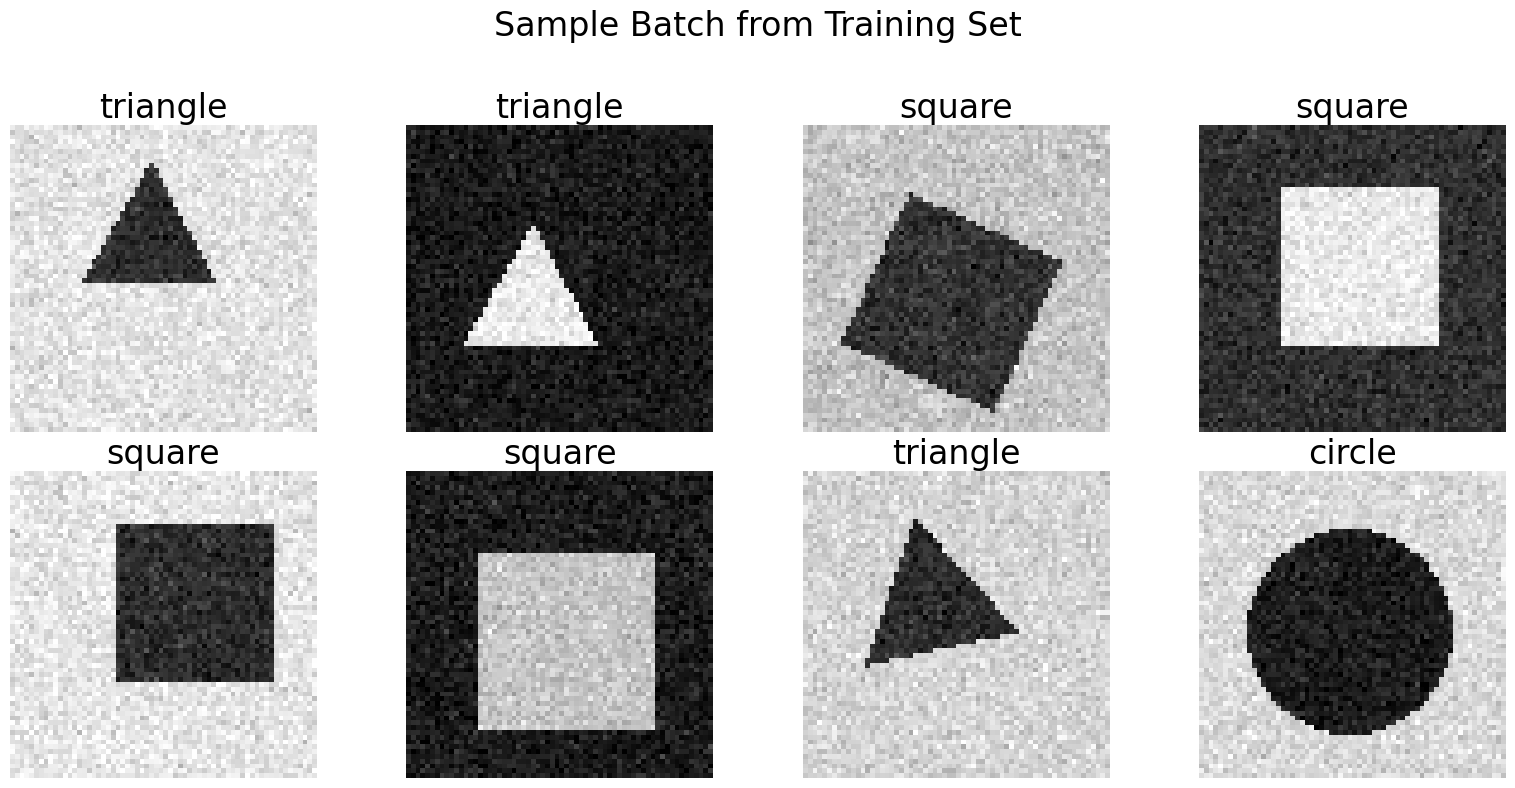

Visualization variables cleared.


In [12]:
def visualize_batch(dataloader, class_names, mean, std, num_images_to_show=8, cols=4):
    """
    Visualizes a batch of images from a dataloader with a flexible grid.
    
    Args:
        dataloader (DataLoader): The dataloader for the training set.
        class_names (list): A list of strings for class names.
        mean (torch.Tensor): The mean used for normalization.
        std (torch.Tensor): The standard deviation used for normalization.
        num_images_to_show (int): The total number of images to display.
        cols (int): The number of columns in the display grid.
    """
    
    # Get one batch of training data
    inputs, classes_idx = next(iter(dataloader))
    
    # Move inputs to CPU for processing with numpy/matplotlib
    inputs = inputs.cpu()
    
    # --- 1. DYNAMIC GRID CALCULATION ---
    # Ensure we don't try to show more images than are in the batch
    num_images_to_show = min(num_images_to_show, len(inputs))
    
    # Calculate the number of rows needed
    rows = math.ceil(num_images_to_show / cols)
    
    # Define figure size dynamically
    figsize = (cols * 4, rows * 4)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle("Sample Batch from Training Set", fontsize=24)

    # Flatten axes array for easy iteration, regardless of grid shape
    axes = axes.flatten()

    # De-normalize and plot each image
    for i in range(num_images_to_show):
        ax = axes[i]
        
        inp = inputs[i].numpy().transpose((1, 2, 0))
        mean_np = np.array([mean.item()])
        std_np = np.array([std.item()])
        inp = std_np * inp + mean_np
        inp = np.clip(inp, 0, 1)
        
        ax.imshow(inp, cmap='gray')
        ax.set_title(class_names[classes_idx[i]], fontsize=24)
        ax.axis('off') # Hide axes ticks

    # If there are any empty subplots left, turn them off
    for i in range(num_images_to_show, len(axes)):
        axes[i].axis('off')

    # --- 2. FIX SPACING ISSUE ---
    # Use fig.tight_layout() with a rect parameter to make space for the suptitle.
    # rect=[left, bottom, right, top] in normalized figure coordinates.
    # The 'top=0.95' leaves 5% of the figure height for the suptitle.
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.show()
    
    # --- Clean up to free memory ---
    del inputs
    del classes_idx
    print("Visualization variables cleared.")

visualize_batch(dataloaders['train'], class_names, mean, std, num_images_to_show=8, cols=4)

## 3. Model Architecture

Here, we define the architecture of our neural network. For this image classification task, a **Convolutional Neural Network (CNN)** is the ideal choice.

### Why a CNN?

CNNs are the industry standard for computer vision tasks for several key reasons:

1.  **Spatial Hierarchy of Features:** Unlike a simple fully-connected network that treats an image as a flat vector of pixels, a CNN processes it as a 2D grid. Its core components, convolutional layers, are designed to learn a hierarchy of features.
    -   **Early layers** automatically learn to detect simple patterns like edges, corners, and gradients.
    -   **Deeper layers** combine these simple patterns to recognize more complex features, such as the curve of a circle or the right-angle corners of a square.

2.  **Parameter Sharing:** A single convolutional filter (e.g., an edge detector) is slid across the entire image. This means the model learns one set of weights for that filter and re-uses it everywhere. This is incredibly efficient compared to a fully-connected layer, which would need a separate weight for every single pixel, leading to an explosion in parameters.

3.  **Translation Invariance:** Because the same filter is applied across the whole image, a CNN can detect a feature (like a triangle corner) regardless of where it appears in the image. This is a direct result of parameter sharing and is crucial for our task, as our shapes are randomly placed.

For this problem, a relatively simple CNN with a few convolutional layers followed by a classifier head is sufficient. It is powerful enough to learn the distinguishing features of our shapes without being so complex that it overfits our synthetic dataset. We do not need a large, pre-trained model like ResNet or a Vision Transformer, as that would be overkill for this task.



## 3. Model Architecture

In this section, we define and explore three different neural network architectures for our image classification task. This allows us to compare their performance and understand their unique strengths.

We will start with a **Simple CNN** as our baseline, then implement a **ResNet-style model** to see the effect of deeper architectures, and finally explore a **Vision Transformer (ViT)**, which represents the state-of-the-art in many computer vision tasks.

### 3.1.1. Model 1: Simple Convolutional Neural Network (CNN)

**Why a CNN?** CNNs are the industry standard for computer vision tasks for several key reasons:

1.  **Spatial Hierarchy of Features:** Unlike a simple fully-connected network that treats an image as a flat vector of pixels, a CNN processes it as a 2D grid. Its core components, convolutional layers, are designed to learn a hierarchy of features.
    -   **Early layers** automatically learn to detect simple patterns like edges, corners, and gradients.
    -   **Deeper layers** combine these simple patterns to recognize more complex features, such as the curve of a circle or the right-angle corners of a square.

2.  **Parameter Sharing:** A single convolutional filter (e.g., an edge detector) is slid across the entire image. This means the model learns one set of weights for that filter and re-uses it everywhere. This is incredibly efficient compared to a fully-connected layer, which would need a separate weight for every single pixel, leading to an explosion in parameters.

3.  **Translation Invariance:** Because the same filter is applied across the whole image, a CNN can detect a feature (like a triangle corner) regardless of where it appears in the image. This is a direct result of parameter sharing and is crucial for our task, as our shapes are randomly placed.

For this problem, a relatively simple CNN with a few convolutional layers followed by a classifier head is sufficient. It is powerful enough to learn the distinguishing features of our shapes without being so complex that it overfits our synthetic dataset.

### 3.1.2. Model 2: Residual Network (ResNet)

**Why ResNet?** As neural networks get deeper, they can suffer from the "vanishing gradient" problem, making them hard to train. ResNet, introduced in 2015, solved this with a simple but revolutionary idea: **residual or "skip" connections**.

A skip connection allows the input of a block of layers to be added to its output. This creates a "shortcut" for the gradient to flow through, enabling the training of much deeper and more powerful networks. For our task, even a simple ResNet-style block can improve performance by allowing for richer feature extraction.

### 3.1.3. Model 3: Vision Transformer (ViT)

**Why ViT?** The Vision Transformer, introduced in 2020, completely changed the computer vision landscape. It adapts the Transformer architecture, originally designed for text processing, to images.

-   **How it Works:** A ViT splits an image into a sequence of smaller, fixed-size patches (like words in a sentence). It then uses the Transformer's **self-attention mechanism** to learn the relationships between these patches.
-   **Strengths:** Self-attention allows the model to weigh the importance of every other patch when processing a given patch, enabling it to learn complex, long-range spatial relationships.
-   **Weaknesses:** ViTs typically require very large datasets to outperform CNNs, but exploring a "micro-ViT" on our small dataset is a valuable learning exercise.

### 3.1.4. Other Potential Architectures

It's worth noting that before deep learning dominated, this problem could have been approached with traditional machine learning models. This would involve a two-step process:
1.  **Feature Extraction:** Manually engineering features from the images using algorithms like HOG (Histogram of Oriented Gradients) or SIFT (Scale-Invariant Feature Transform).

2.  **Classification:** Feeding these features into a classic classifier like a Support Vector Machine (SVM) or a Random Forest.
While effective, this approach is less powerful as it relies on hand-crafted features, whereas a deep learning model learns the optimal features automatically.

In [13]:
# ===================================================================
# Model 1: SimpleCNN
# ===================================================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # --- Convolutional Layers ---
        # Our input is a 64x64 grayscale image (1 channel).
        self.features = nn.Sequential(
            # Layer 1
            # Input: 1 x 64 x 64
            # Output: 16 x 32 x 32
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2
            # Input: 16 x 32 x 32
            # Output: 32 x 16 x 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3
            # Input: 32 x 16 x 16
            # Output: 64 x 8 x 8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # --- Classifier (Fully Connected Layers) ---
        # After 3 max-pooling layers of stride 2, our 64x64 image is now 8x8.
        # So the flattened feature map size is 64 channels * 8 * 8 = 4096.
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout for regularization
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        # Flatten the feature map to a vector before feeding it to the classifier
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

# ===================================================================
# Model 2: SimpleResNet
# ===================================================================
class ResidualBlock(nn.Module):
    """
    A residual block, the fundamental building block of ResNet architectures.
    It allows for the creation of deeper networks by adding a "shortcut" or "skip"
    connection, which helps mitigate the vanishing gradient problem.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Main path of the residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions if they change (e.g., due to stride or channel changes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Use a 1x1 convolution to resize the input 'x' to match the output dimension
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # The output of the main path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # The magic: add the original input (or its projection) to the output of the conv layers
        out += self.shortcut(x) 
        out = self.relu(out)
        return out

class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleResNet, self).__init__()
        self.in_channels = 16
        
        # --- Initial Convolution (Stem) ---
        # Input: 1 x 64 x 64 -> Output: 16 x 64 x 64
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # --- Residual Layers ---
        # Stacks of residual blocks. Downsampling is done by setting stride=2 in the first block of a layer.
        # Input: 16 x 64 x 64 -> Output: 16 x 64 x 64
        self.layer1 = self._make_layer(16, num_blocks=2, stride=1)
        # Input: 16 x 64 x 64 -> Output: 32 x 32 x 32
        self.layer2 = self._make_layer(32, num_blocks=2, stride=2)
        # Input: 32 x 32 x 32 -> Output: 64 x 16 x 16
        self.layer3 = self._make_layer(64, num_blocks=2, stride=2)
        
        # --- Classifier ---
        # Adaptive Average Pooling flattens the spatial dimensions to 1x1, making the model
        # robust to different input sizes. Output size will be (batch_size, 64, 1, 1).
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Final linear layer. The input features will be 64 (from the last layer's out_channels).
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        """Helper function to create a layer with multiple residual blocks."""
        # The first block in a layer might have a different stride for downsampling.
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, s))
            self.in_channels = out_channels # Update in_channels for the next block
        return nn.Sequential(*layers)

    def forward(self, x):
        # Pass through the initial stem
        out = self.relu(self.bn1(self.conv1(x)))
        # Pass through the residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Pool and flatten
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        # Classify
        out = self.linear(out)
        return out

# ===================================================================
# Model 3: SimpleViT (Vision Transformer)
# ===================================================================
class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim):
        super().__init__()
        # --- Configuration ---
        # An image is treated as a sequence of patches.
        # For a 64x64 image with 16x16 patches, we get (64/16)^2 = 16 patches.
        num_patches = (image_size // patch_size) ** 2
        # The dimension of a single flattened patch (e.g., 1 channel * 16 * 16 = 256).
        patch_dim = 1 * patch_size ** 2

        # --- Patching and Embedding ---
        # A linear layer to project flattened patches into a higher-dimensional vector space (dim).
        self.patch_embedding = nn.Linear(patch_dim, dim)
        # Learnable positional embeddings to give the model spatial information.
        # We add 1 to num_patches for the [CLS] token.
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        # A special learnable token that is prepended to the sequence of patches.
        # Its final output state is used for classification.
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # --- Transformer Encoder ---
        # The core of the model: a stack of Transformer Encoder layers.
        # This is where self-attention allows patches to interact and weigh their importance.
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # --- Classifier Head ---
        self.to_latent = nn.Identity()
        # A simple linear layer that takes the final state of the [CLS] token and maps it to class scores.
        self.linear_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        # Input image shape: (batch_size, 1, 64, 64)
        
        # --- 1. Patching ---
        # Use `unfold` to create non-overlapping patches. Here, we create 16x16 patches.
        # `unfold(dim, size, step)`
        p = img.unfold(2, 16, 16).unfold(3, 16, 16)
        # Reshape to (batch_size, num_patches, patch_dim)
        p = p.reshape(img.shape[0], -1, 1 * 16 * 16) # (batch, 16, 256)
        
        # --- 2. Embedding ---
        # Project patches to the embedding dimension `dim`.
        x = self.patch_embedding(p) # (batch, 16, dim)
        b, n, _ = x.shape # b=batch_size, n=num_patches

        # Prepend the [CLS] token to the sequence of patch embeddings.
        cls_tokens = self.cls_token.expand(b, -1, -1) # (batch, 1, dim)
        x = torch.cat((cls_tokens, x), dim=1) # (batch, 17, dim)

        # Add positional embedding to give the model spatial context.
        x += self.pos_embedding[:, :(n + 1)]
        
        # --- 3. Transformer ---
        # Pass the sequence of embeddings through the transformer encoder.
        x = self.transformer(x) # (batch, 17, dim)
        
        # --- 4. Classification ---
        # Take only the output corresponding to the [CLS] token (at index 0).
        x = self.to_latent(x[:, 0]) # (batch, dim)
        
        # Pass the [CLS] token's representation through the final linear head.
        return self.linear_head(x) # (batch, num_classes)

# ===================================================================
# Model Instantiation and Testing
# ===================================================================
def test_model_output(model_instance):
    """A quick test to see the output shape of a sample batch."""
    print(f"\n--- Testing Model: {model_instance.__class__.__name__} ---")
    model_instance.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Get a sample batch and move it to the device
        sample_batch, _ = next(iter(dataloaders['train']))
        sample_batch = sample_batch.to(DEVICE)
        
        # Get model output
        output = model_instance(sample_batch)
        
        # Print results and clean up
        print(f"Input batch shape: {sample_batch.shape}")
        print(f"Output batch shape: {output.shape}")
        assert output.shape == (BATCH_SIZE, NUM_CLASSES), "Output shape is incorrect!"
        print("Model test passed.\n")

    # --- Clean up to free memory ---
    del sample_batch, _, output
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Test variables and GPU cache cleared.")


# ===================================================================
# A better way to test models if memory is a concern
# ===================================================================

# A list of model classes and their specific configurations
models_to_test = [
    ("SimpleCNN", SimpleCNN, {"num_classes": NUM_CLASSES}),
    ("SimpleResNet", SimpleResNet, {"num_classes": NUM_CLASSES}),
    ("SimpleViT", SimpleViT, {
        "image_size": 64, "patch_size": 16, "num_classes": NUM_CLASSES,
        "dim": 64, "depth": 2, "heads": 4, "mlp_dim": 128
    })
]

for name, model_class, kwargs in models_to_test:
    print("="*50)
    print(f"Now processing: {name}")
    # 1. Instantiate the single model and move it to the GPU
    model = model_class(**kwargs).to(DEVICE)
    # 2. Run the test on this specific model
    test_model_output(model)
    # 3. Explicitly delete the model to free up memory
    print(f"Deleting model '{name}' to free memory...")
    del model
    # 4. CRITICAL: Clear the PyTorch cache. This releases the memory
    # that the deleted model was occupying back to the GPU.
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(f"Finished processing and cleaning up {name}.")
    print("="*50)

Now processing: SimpleCNN

--- Testing Model: SimpleCNN ---
Input batch shape: torch.Size([32, 1, 64, 64])
Output batch shape: torch.Size([32, 3])
Model test passed.

Test variables and GPU cache cleared.
Deleting model 'SimpleCNN' to free memory...
Finished processing and cleaning up SimpleCNN.
Now processing: SimpleResNet

--- Testing Model: SimpleResNet ---
Input batch shape: torch.Size([32, 1, 64, 64])
Output batch shape: torch.Size([32, 3])
Model test passed.

Test variables and GPU cache cleared.
Deleting model 'SimpleResNet' to free memory...
Finished processing and cleaning up SimpleResNet.
Now processing: SimpleViT

--- Testing Model: SimpleViT ---
Input batch shape: torch.Size([32, 1, 64, 64])
Output batch shape: torch.Size([32, 3])
Model test passed.

Test variables and GPU cache cleared.
Deleting model 'SimpleViT' to free memory...
Finished processing and cleaning up SimpleViT.


## 4. Training the Model

With our data pipeline and model architectures in place, we now turn to the training process itself. This involves defining the components that will guide our model's learning.

This section contains the logic for training the model, including:
*   Defining the loss function and optimizer.
*   Implementing the training and validation loops.
*   Incorporating early stopping and model checkpointing to save the best-performing model.

### 4.1. Training Settings: Loss, Optimizer, and Scheduler

#### Loss Function
The **loss function** quantifies how "wrong" our model's predictions are compared to the true labels. For a multi-class classification problem like ours, the industry-standard choice is **Cross-Entropy Loss**.

PyTorch's `nn.CrossEntropyLoss` is particularly powerful because it internally combines two operations:
1.  `LogSoftmax`: It converts the model's raw output scores (logits) into a probability distribution.
2.  `NLLLoss` (Negative Log Likelihood Loss): It then calculates the loss based on these probabilities.
This combined approach is numerically more stable and efficient than applying the two layers separately.

#### Optimizer
The **optimizer** is the algorithm that updates the model's weights (parameters) to minimize the loss. We will use the **Adam (Adaptive Moment Estimation)** optimizer.

Adam is a highly effective and popular choice because:
-   It is an **adaptive learning rate** method, meaning it maintains a separate learning rate for each parameter and adjusts it as training progresses, often leading to faster convergence than standard Stochastic Gradient Descent (SGD).
-   It combines the advantages of two other popular optimizers (AdaGrad and RMSProp), making it robust and generally requiring less manual tuning of the initial learning rate.

#### Learning Rate Scheduler
A **learning rate scheduler** dynamically adjusts the learning rate during training. A common strategy is to start with a relatively high learning rate to converge quickly and then decrease it to take smaller, more precise steps as the model gets closer to a solution.

We will use `ReduceLROnPlateau`. This scheduler monitors a chosen metric (in our case, the **validation loss**). If the validation loss stops improving for a set number of epochs (a "patience" period), the scheduler will reduce the learning rate by a specified factor. This is an intelligent, reactive strategy that adapts to the model's actual performance.

In [14]:
# --- Hyperparameters for Training ---
# We define these here to keep them in one place.
# The optimizer and scheduler will be instantiated inside the training function
# because they are tied to a specific model's parameters.
LEARNING_RATE = 0.001
NUM_EPOCHS = 50 # This is a maximum; we will use Early Stopping.

# --- Loss Function ---
# This is model-agnostic, so we can define it once.
criterion = nn.CrossEntropyLoss()

print("Training settings and loss function defined:\n")

print("Loss function defined: CrossEntropyLoss")
print("Optimizer choice: Adam")
print("LR Scheduler choice: ReduceLROnPlateau")

Training settings and loss function defined:

Loss function defined: CrossEntropyLoss
Optimizer choice: Adam
LR Scheduler choice: ReduceLROnPlateau


### 4.2. The Main Training Loop Function

This is the most critical function in our notebook. The `train_model` function encapsulates the entire process of training a model for a set number of epochs. It is designed to be generic, accepting any of our defined model architectures as input.

A robust training loop involves several key components:

1.  **Epoch Iteration:** A main loop that iterates over the specified number of epochs.
2.  **Training & Validation Phases:** Within each epoch, the model goes through two distinct phases:
    -   **The `training` phase (`model.train()`):** The model processes the training data, calculates the loss, and uses backpropagation to update its weights. Layers like Dropout and BatchNorm are active in this mode.
    -   **The `validation` phase (`model.eval()`):** The model processes the unseen validation data to evaluate its performance. No weight updates occur. Layers like Dropout and BatchNorm are disabled to ensure deterministic output for evaluation.
3.  **Metric Tracking:** We carefully track and store the loss and accuracy for both training and validation at each epoch. This history is crucial for later analysis and plotting.
4.  **Model Checkpointing:** We don't want to just keep the model from the final epoch; we want the model from the *best* epoch. The loop monitors the validation loss and saves the model's weights (`state_dict`) only when it achieves a new best performance.
5.  **Early Stopping:** To save time and prevent overfitting, we implement an "early stopping" mechanism. If the validation loss does not improve for a set number of consecutive epochs (our "patience"), we halt the training process, assuming the model has converged.
6.  **Return Values:** After training is complete (either by reaching the max epochs or by early stopping), the function loads the best saved weights back into the model and returns both the best model and its performance history.

In [17]:
def clear_gpu_cache():
    """Clears the PyTorch CUDA cache to free up VRAM."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def train_model(
    model: nn.Module,
    model_name: str,
    dataloaders: dict,
    criterion: nn.Module,
    learning_rate: float,
    num_epochs: int,
    checkpoint_dir: str,
    stop_file_dir: str = None,
    resume_from: str = 'best',
    top_k: int = 3,
    patience: int = 5
):
    """
    Trains and validates a PyTorch model with advanced features.

    This function handles the entire training loop, including:
    - Experiment directory management for checkpoints, plots, and history.
    - Automatic resumption of training from the last or best checkpoint.
    - Top-K checkpointing to save only the best models based on validation loss.
    - Live plotting of training/validation metrics in a Jupyter Notebook.
    - Rich checkpoint saving (model, optimizer, epoch, etc.).
    - Learning rate scheduling and early stopping.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        model_name (str): A name for the model, used in filenames.
        dataloaders (dict): Dictionary with 'train' and 'validation' PyTorch DataLoaders.
        criterion (nn.Module): The loss function.
        learning_rate (float): The initial learning rate for the optimizer.
        num_epochs (int): The total number of epochs to train for.
        checkpoint_dir (str): The specific directory for this experiment's artifacts.
                              If it contains checkpoints, training will resume.
        stop_file_dir (str, optional): The path to a directory where the function will
                                       check for a stop signal file. If a file named 'STOP'
                                       is found within this directory at the beginning of an
                                       epoch, training will halt gracefully. The signal file
                                       will be renamed to 'STOP_acknowledged' to prevent it
                                       from stopping subsequent runs. Defaults to None.
        resume_from (str, optional): If resuming, specifies which checkpoint to use.
                                     Can be 'best' or 'last'. Defaults to 'best'.
        top_k (int, optional): The number of best checkpoints to keep. Defaults to 3.
        patience (int, optional): Number of epochs to wait for validation loss
                                  improvement before stopping early. Defaults to 5.

    Returns:
        tuple: A tuple containing:
            - nn.Module: The model loaded with the weights from the best checkpoint.
            - dict: A dictionary containing the full training history.
    """
    # ======================================================================================
    # 1. SETUP & INITIALIZATION
    # ======================================================================================
    start_time = time.time()
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"--- Experiment artifacts will be saved in: {checkpoint_dir} ---")

    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience // 2)

    # --- Initialize training state variables ---
    start_epoch = 0
    history = {'train_loss': [], 'train_acc': [], 'validation_loss': [], 'validation_acc': []}
    top_k_checkpoints = []  # List of {'loss': float, 'path': str}
    best_val_loss = float('inf')
    early_stopping_counter = 0

    # ======================================================================================
    # 2. RESUME FROM CHECKPOINT (if applicable)
    # ======================================================================================
    history_path = os.path.join(checkpoint_dir, 'history.json')
    top_k_path = os.path.join(checkpoint_dir, 'top_k_checkpoints.json')
    last_ckpt_path = os.path.join(checkpoint_dir, 'last_epoch.pth')

    if os.path.exists(history_path) and os.path.exists(top_k_path):
        print("Found existing experiment data. Attempting to resume training...")
        
        # Determine which checkpoint file to load
        if resume_from == 'best' and os.path.exists(top_k_path):
            with open(top_k_path, 'r') as f:
                saved_top_k = json.load(f)
            if saved_top_k:
                resume_ckpt_path = saved_top_k[0]['path'] # Best is always first
                print(f"Resuming from the BEST checkpoint: {resume_ckpt_path}")
            else:
                resume_ckpt_path = last_ckpt_path
                print(f"Top-K list was empty. Resuming from LAST checkpoint: {resume_ckpt_path}")

        elif resume_from == 'last' and os.path.exists(last_ckpt_path):
            resume_ckpt_path = last_ckpt_path
            print(f"Resuming from the LAST checkpoint: {resume_ckpt_path}")
        else:
            resume_ckpt_path = None
            print("Could not find a suitable checkpoint to resume from. Starting fresh.")

        if resume_ckpt_path and os.path.exists(resume_ckpt_path):
            checkpoint = torch.load(resume_ckpt_path, map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            
            # Load history and top-k list to continue tracking
            with open(history_path, 'r') as f:
                history = json.load(f)
            with open(top_k_path, 'r') as f:
                top_k_checkpoints = json.load(f)
            
            best_val_loss = min(history['validation_loss']) if history['validation_loss'] else float('inf')
            
            print(f"Successfully resumed from epoch {start_epoch}. Previous best validation_loss: {best_val_loss:.4f}")
            # Ensure we don't re-run the last epoch
            if start_epoch >= num_epochs:
                print("Warning: Resumed from an epoch number >= num_epochs. Training will not run.")

    # ======================================================================================
    # 3. LIVE PLOT SETUP
    # ======================================================================================
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    display_handle = display(fig, display_id=True)
    fig.suptitle(f'Training {model_name}', fontsize=16)
    fig_plot_path = os.path.join(checkpoint_dir, 'training_curves.png')

    def update_live_plot(history_data):
        # Loss subplot
        ax1.clear()
        ax1.plot(history_data['train_loss'], label='Train Loss')
        ax1.plot(history_data['validation_loss'], label='Validation Loss')
        ax1.set_title('Loss vs. Epochs')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        # Accuracy subplot
        ax2.clear()
        ax2.plot(history_data['train_acc'], label='Train Accuracy')
        ax2.plot(history_data['validation_acc'], label='Validation Accuracy')
        ax2.set_title('Accuracy vs. Epochs')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        display_handle.update(fig)

    # ======================================================================================
    # 4. MAIN TRAINING LOOP
    # ======================================================================================
    print(f"\n--- Starting training from epoch {start_epoch + 1} to {num_epochs} ---")
    # Define the path for the stop signal file, located next to the script.
    if stop_file_dir:
        stop_file_path = os.path.join(stop_file_dir, 'STOP')

    for epoch in range(start_epoch, num_epochs):
        # <-- Stop signal check
        if stop_file_dir and os.path.exists(stop_file_path):
            print(f"\nStop signal file detected at \n'{stop_file_path}'.")
            print(f"Gracefully shutting down before epoch {epoch}...")
            os.rename(stop_file_path, stop_file_path + '_acknowledged')
            clear_gpu_cache()
            break

        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}\n" + '-' * 15)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for a progress bar over the data
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}")
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                progress_bar.set_postfix(
                    loss=running_loss / (progress_bar.n + 1) / inputs.size(0),
                    acc=running_corrects.double().item() / (progress_bar.n + 1) / inputs.size(0)
                )

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize():<12} -> Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')

            # Store history for this epoch
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

        # ======================================================================================
        # 5. POST-EPOCH ACTIONS
        # ======================================================================================
        current_val_loss = history['validation_loss'][-1]
        
        # --- Update Live Plot and Persistent History ---
        update_live_plot(history)
        fig.savefig(fig_plot_path)
        with open(history_path, 'w') as f:
            json.dump(history, f, indent=4)
        
        # --- Learning Rate Scheduler ---
        scheduler.step(current_val_loss)

        # Create rich checkpoint dictionary
        # Always save the state of the last completed epoch
        checkpoint = {
            'epoch': epoch + 1,
            "train_loss": history['train_loss'][-1],
            "train_acc": history['train_acc'][-1],
            'validation_loss': current_val_loss,
            "validation_acc": history['validation_acc'][-1],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'learning_rate': optimizer.param_groups[0]['lr'],
        }

        # --- Top-K Checkpointing Logic ---
        is_best_so_far = len(top_k_checkpoints) < top_k or current_val_loss < top_k_checkpoints[-1]['loss']
        if is_best_so_far:
            # Define checkpoint path and save
            ckpt_filename = f"epoch_{epoch+1:03d}_valloss_{current_val_loss:.4f}.pth"
            save_path = os.path.join(checkpoint_dir, ckpt_filename)
            
            torch.save(checkpoint, save_path)
            print(f"✓ Top-K Checkpoint saved: {save_path}")

            # Add to top-k list and sort
            top_k_checkpoints.append({'loss': current_val_loss, 'path': save_path})
            top_k_checkpoints.sort(key=lambda x: x['loss'])

            # If list is too long, remove the worst checkpoint
            if len(top_k_checkpoints) > top_k:
                worst_checkpoint = top_k_checkpoints.pop()
                if os.path.exists(worst_checkpoint['path']):
                    os.remove(worst_checkpoint['path'])
                    print(f"✗ Removed worst checkpoint: {os.path.basename(worst_checkpoint['path'])}")
        
        # --- Save `last_epoch.pth` and `top_k_checkpoints.json` ---
        # Always save the state of the last completed epoch

        torch.save(checkpoint, last_ckpt_path)
        # Persist the list of top-k models
        with open(top_k_path, 'w') as f:
            json.dump(top_k_checkpoints, f, indent=4)
            
        # --- Early Stopping ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch finished in {epoch_time:.2f}s. Early stopping counter: {early_stopping_counter}/{patience}")

        if early_stopping_counter >= patience:
            print(f"\n! Early stopping triggered after {patience} epochs of no improvement.")
            break

    # ======================================================================================
    # 6. FINALIZATION
    # ======================================================================================
    plt.ioff() # Turn off interactive mode
    update_live_plot(history) # Draw final plot
    fig.savefig(fig_plot_path)
    plt.close(fig) # Close the figure to avoid displaying it again

    time_elapsed = time.time() - start_time
    print(f'\n--- Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s ---')
    print(f'Final plot saved to: {fig_plot_path}')
    print(f'Training history saved to: {history_path}')
    
    # ======================================================================================
    # 7. RETURN BEST MODEL
    # ======================================================================================
    if not top_k_checkpoints:
        print("\nWarning: No checkpoints were saved. The model from the last epoch will be used.")
        # No return here! Let the code flow to the cleanup section.
    else:
        # This 'else' block makes the logic clearer
        best_model_path = top_k_checkpoints[0]['path']
        print(f"\nLoading best model weights from: {best_model_path}")
        best_checkpoint = torch.load(best_model_path, map_location=DEVICE)
        model.load_state_dict(best_checkpoint['model_state_dict'])

        print("\n--- Top Checkpoints by Validation Loss ---")
        for i, ckpt in enumerate(top_k_checkpoints):
            print(f"{i+1}. Loss: {ckpt['loss']:.4f}, Path: {os.path.basename(ckpt['path'])}")

    # ======================================================================================
    # 8. FINAL CLEANUP
    # ======================================================================================
    print("\nPerforming automated final cleanup to free memory...")
    
    # --- Stage 1: Define the small set of variables to PRESERVE ---
    # These are the objects that must survive because they are returned to the caller.
    vars_to_preserve = {'model', 'history'}

    # --- Stage 2: Automatically identify and delete all other local variables ---
    # We iterate over a copy of the local variable keys to avoid issues with
    # modifying the dictionary while looping.
    all_local_vars = list(locals().keys())
    
    deleted_count = 0
    print("Cleaning up internal variables...")
    for var_name in all_local_vars:
        # The key condition: delete it if it's NOT in our preserve list.
        if var_name not in vars_to_preserve:
            # We use 'del locals()[var_name]' to delete a variable by its string name.
            # This is safe because locals() gives us the dictionary of this function's scope.
            print(var_name)
            try:
                del locals()[var_name]
                deleted_count += 1
            except KeyError:
                # This can happen in some edge cases, perfectly safe to ignore.
                pass

    print(f"Successfully deleted {deleted_count} internal variables.")

    # --- Stage 3: Trigger garbage collection and empty CUDA cache ---
    # Clear the PyTorch CUDA cache to free up reserved but unused VRAM
    clear_gpu_cache()
    # Run Python's garbage collector to reclaim memory from deleted objects
    gc.collect()
    
    print("Internal cleanup complete. Returning best model and history.")

    return model, history

### 4.3. Execute Training Runs

This section serves as the main "controller" for our experiments. Here, we can select which of our defined model architectures we wish to train.

The logic is straightforward:
1.  We define a list, `models_to_train`, containing the names of the models we want to process in this run.
2.  We iterate through this list. For each model, we:
    -   Create a **unique timestamped directory** for the experiment's artifacts (checkpoints, plots, history). This ensures that every training run is saved independently and nothing is overwritten.
    -   Call our powerful `train_model` function, passing the specific model and its unique directory.
    -   Store the returned best model and its training history in dictionaries for later use in the evaluation phase.

This modular approach allows us to easily train one, two, or all three models and compare their results fairly.


INITIALIZING TRAINING RUN FOR: CNN
--- Experiment artifacts will be saved in: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340 ---


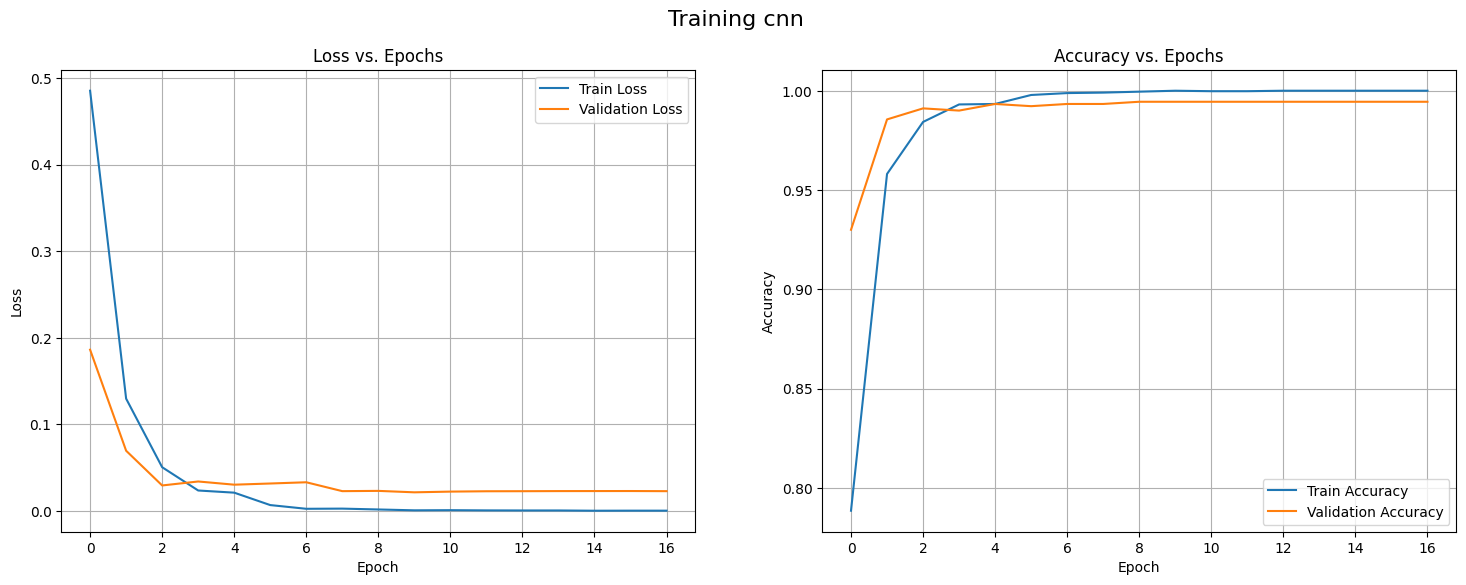


--- Starting training from epoch 1 to 50 ---

Epoch 1/50
---------------


Train Epoch 1:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.4852 | Acc: 0.7886


Validation Epoch 1:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1863 | Acc: 0.9300
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_001_valloss_0.1863.pth
Epoch finished in 21.67s. Early stopping counter: 0/7

Epoch 2/50
---------------


Train Epoch 2:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.1298 | Acc: 0.9581


Validation Epoch 2:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0697 | Acc: 0.9856
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_002_valloss_0.0697.pth
Epoch finished in 2.30s. Early stopping counter: 0/7

Epoch 3/50
---------------


Train Epoch 3:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0506 | Acc: 0.9843


Validation Epoch 3:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0296 | Acc: 0.9911
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_003_valloss_0.0296.pth
Epoch finished in 2.34s. Early stopping counter: 0/7

Epoch 4/50
---------------


Train Epoch 4:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0238 | Acc: 0.9931


Validation Epoch 4:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0342 | Acc: 0.9900
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_004_valloss_0.0342.pth
✗ Removed worst checkpoint: epoch_001_valloss_0.1863.pth
Epoch finished in 2.53s. Early stopping counter: 1/7

Epoch 5/50
---------------


Train Epoch 5:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0213 | Acc: 0.9933


Validation Epoch 5:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0305 | Acc: 0.9933
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_005_valloss_0.0305.pth
✗ Removed worst checkpoint: epoch_002_valloss_0.0697.pth
Epoch finished in 2.68s. Early stopping counter: 2/7

Epoch 6/50
---------------


Train Epoch 6:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0069 | Acc: 0.9979


Validation Epoch 6:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0318 | Acc: 0.9922
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_006_valloss_0.0318.pth
✗ Removed worst checkpoint: epoch_004_valloss_0.0342.pth
Epoch finished in 2.67s. Early stopping counter: 3/7

Epoch 7/50
---------------


Train Epoch 7:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0027 | Acc: 0.9988


Validation Epoch 7:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0333 | Acc: 0.9933
Epoch finished in 2.62s. Early stopping counter: 4/7

Epoch 8/50
---------------


Train Epoch 8:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0029 | Acc: 0.9990


Validation Epoch 8:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0230 | Acc: 0.9933
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_008_valloss_0.0230.pth
✗ Removed worst checkpoint: epoch_006_valloss_0.0318.pth
Epoch finished in 2.67s. Early stopping counter: 0/7

Epoch 9/50
---------------


Train Epoch 9:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0019 | Acc: 0.9995


Validation Epoch 9:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0233 | Acc: 0.9944
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_009_valloss_0.0233.pth
✗ Removed worst checkpoint: epoch_005_valloss_0.0305.pth
Epoch finished in 2.63s. Early stopping counter: 1/7

Epoch 10/50
---------------


Train Epoch 10:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0009 | Acc: 1.0000


Validation Epoch 10:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0217 | Acc: 0.9944
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_010_valloss_0.0217.pth
✗ Removed worst checkpoint: epoch_003_valloss_0.0296.pth
Epoch finished in 2.61s. Early stopping counter: 0/7

Epoch 11/50
---------------


Train Epoch 11:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0011 | Acc: 0.9998


Validation Epoch 11:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0225 | Acc: 0.9944
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_011_valloss_0.0225.pth
✗ Removed worst checkpoint: epoch_009_valloss_0.0233.pth
Epoch finished in 2.61s. Early stopping counter: 1/7

Epoch 12/50
---------------


Train Epoch 12:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0008 | Acc: 0.9998


Validation Epoch 12:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0229 | Acc: 0.9944
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_012_valloss_0.0229.pth
✗ Removed worst checkpoint: epoch_008_valloss_0.0230.pth
Epoch finished in 2.68s. Early stopping counter: 2/7

Epoch 13/50
---------------


Train Epoch 13:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0007 | Acc: 1.0000


Validation Epoch 13:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0230 | Acc: 0.9944
Epoch finished in 2.61s. Early stopping counter: 3/7

Epoch 14/50
---------------


Train Epoch 14:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0007 | Acc: 1.0000


Validation Epoch 14:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0231 | Acc: 0.9944
Epoch finished in 2.64s. Early stopping counter: 4/7

Epoch 15/50
---------------


Train Epoch 15:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0004 | Acc: 1.0000


Validation Epoch 15:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0231 | Acc: 0.9944
Epoch finished in 2.60s. Early stopping counter: 5/7

Epoch 16/50
---------------


Train Epoch 16:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0005 | Acc: 1.0000


Validation Epoch 16:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0232 | Acc: 0.9944
Epoch finished in 2.66s. Early stopping counter: 6/7

Epoch 17/50
---------------


Train Epoch 17:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0005 | Acc: 1.0000


Validation Epoch 17:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0230 | Acc: 0.9944
Epoch finished in 2.62s. Early stopping counter: 7/7

! Early stopping triggered after 7 epochs of no improvement.

--- Training complete in 1m 3s ---
Final plot saved to: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\training_curves.png
Training history saved to: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\history.json

Loading best model weights from: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\cnn_20250811_162340\epoch_010_valloss_0.0217.pth

--- Top Checkpoints by Validation Loss ---


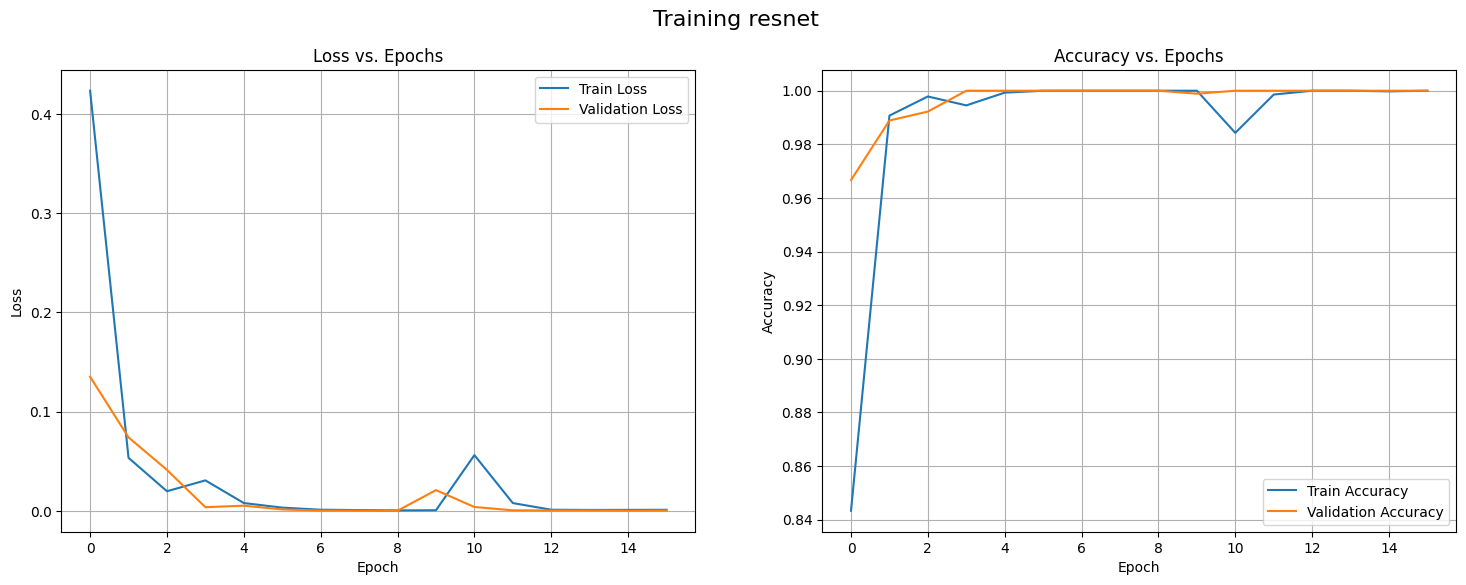


--- Starting training from epoch 1 to 50 ---

Epoch 1/50
---------------


Train Epoch 1:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.4234 | Acc: 0.8433


Validation Epoch 1:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1353 | Acc: 0.9667
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_001_valloss_0.1353.pth
Epoch finished in 3.16s. Early stopping counter: 0/7

Epoch 2/50
---------------


Train Epoch 2:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0535 | Acc: 0.9907


Validation Epoch 2:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0742 | Acc: 0.9889
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_002_valloss_0.0742.pth
Epoch finished in 2.90s. Early stopping counter: 0/7

Epoch 3/50
---------------


Train Epoch 3:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0199 | Acc: 0.9979


Validation Epoch 3:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0414 | Acc: 0.9922
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_003_valloss_0.0414.pth
Epoch finished in 2.96s. Early stopping counter: 0/7

Epoch 4/50
---------------


Train Epoch 4:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0308 | Acc: 0.9945


Validation Epoch 4:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0038 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_004_valloss_0.0038.pth
✗ Removed worst checkpoint: epoch_001_valloss_0.1353.pth
Epoch finished in 2.92s. Early stopping counter: 0/7

Epoch 5/50
---------------


Train Epoch 5:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0080 | Acc: 0.9993


Validation Epoch 5:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0053 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_005_valloss_0.0053.pth
✗ Removed worst checkpoint: epoch_002_valloss_0.0742.pth
Epoch finished in 2.89s. Early stopping counter: 1/7

Epoch 6/50
---------------


Train Epoch 6:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0034 | Acc: 1.0000


Validation Epoch 6:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0015 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_006_valloss_0.0015.pth
✗ Removed worst checkpoint: epoch_003_valloss_0.0414.pth
Epoch finished in 2.90s. Early stopping counter: 0/7

Epoch 7/50
---------------


Train Epoch 7:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0013 | Acc: 1.0000


Validation Epoch 7:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0004 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_007_valloss_0.0004.pth
✗ Removed worst checkpoint: epoch_005_valloss_0.0053.pth
Epoch finished in 2.93s. Early stopping counter: 0/7

Epoch 8/50
---------------


Train Epoch 8:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0009 | Acc: 1.0000


Validation Epoch 8:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0003 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_008_valloss_0.0003.pth
✗ Removed worst checkpoint: epoch_004_valloss_0.0038.pth
Epoch finished in 2.90s. Early stopping counter: 0/7

Epoch 9/50
---------------


Train Epoch 9:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0006 | Acc: 1.0000


Validation Epoch 9:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0002 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_009_valloss_0.0002.pth
✗ Removed worst checkpoint: epoch_006_valloss_0.0015.pth
Epoch finished in 2.93s. Early stopping counter: 0/7

Epoch 10/50
---------------


Train Epoch 10:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0007 | Acc: 1.0000


Validation Epoch 10:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0210 | Acc: 0.9989
Epoch finished in 2.88s. Early stopping counter: 1/7

Epoch 11/50
---------------


Train Epoch 11:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0562 | Acc: 0.9843


Validation Epoch 11:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0040 | Acc: 1.0000
Epoch finished in 2.90s. Early stopping counter: 2/7

Epoch 12/50
---------------


Train Epoch 12:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0079 | Acc: 0.9986


Validation Epoch 12:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0007 | Acc: 1.0000
Epoch finished in 2.90s. Early stopping counter: 3/7

Epoch 13/50
---------------


Train Epoch 13:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0013 | Acc: 1.0000


Validation Epoch 13:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0005 | Acc: 1.0000
Epoch finished in 2.94s. Early stopping counter: 4/7

Epoch 14/50
---------------


Train Epoch 14:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0011 | Acc: 1.0000


Validation Epoch 14:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0005 | Acc: 1.0000
Epoch finished in 2.95s. Early stopping counter: 5/7

Epoch 15/50
---------------


Train Epoch 15:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0011 | Acc: 0.9998


Validation Epoch 15:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0003 | Acc: 1.0000
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_015_valloss_0.0003.pth
✗ Removed worst checkpoint: epoch_007_valloss_0.0004.pth
Epoch finished in 2.94s. Early stopping counter: 6/7

Epoch 16/50
---------------


Train Epoch 16:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0012 | Acc: 1.0000


Validation Epoch 16:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.0005 | Acc: 1.0000
Epoch finished in 2.90s. Early stopping counter: 7/7

! Early stopping triggered after 7 epochs of no improvement.

--- Training complete in 0m 47s ---
Final plot saved to: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\training_curves.png
Training history saved to: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\history.json

Loading best model weights from: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\resnet_20250811_162444\epoch_009_valloss_0.0002.pth

--- Top Checkpoints by Validation

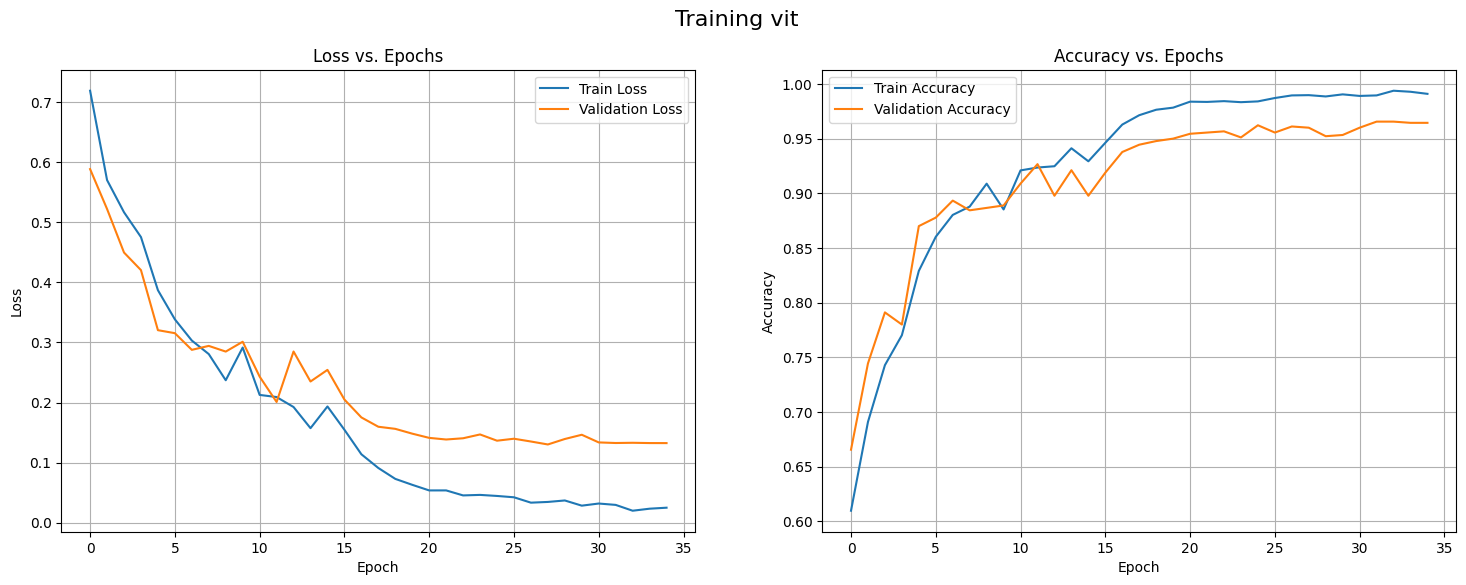


--- Starting training from epoch 1 to 50 ---

Epoch 1/50
---------------


Train Epoch 1:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.7190 | Acc: 0.6098


Validation Epoch 1:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.5886 | Acc: 0.6656
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_001_valloss_0.5886.pth
Epoch finished in 2.43s. Early stopping counter: 0/7

Epoch 2/50
---------------


Train Epoch 2:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.5703 | Acc: 0.6910


Validation Epoch 2:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.5222 | Acc: 0.7444
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_002_valloss_0.5222.pth
Epoch finished in 2.53s. Early stopping counter: 0/7

Epoch 3/50
---------------


Train Epoch 3:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.5167 | Acc: 0.7429


Validation Epoch 3:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.4497 | Acc: 0.7911
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_003_valloss_0.4497.pth
Epoch finished in 2.72s. Early stopping counter: 0/7

Epoch 4/50
---------------


Train Epoch 4:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.4754 | Acc: 0.7702


Validation Epoch 4:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.4204 | Acc: 0.7800
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_004_valloss_0.4204.pth
✗ Removed worst checkpoint: epoch_001_valloss_0.5886.pth
Epoch finished in 2.78s. Early stopping counter: 0/7

Epoch 5/50
---------------


Train Epoch 5:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.3870 | Acc: 0.8290


Validation Epoch 5:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.3205 | Acc: 0.8700
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_005_valloss_0.3205.pth
✗ Removed worst checkpoint: epoch_002_valloss_0.5222.pth
Epoch finished in 2.85s. Early stopping counter: 0/7

Epoch 6/50
---------------


Train Epoch 6:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.3385 | Acc: 0.8602


Validation Epoch 6:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.3155 | Acc: 0.8778
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_006_valloss_0.3155.pth
✗ Removed worst checkpoint: epoch_003_valloss_0.4497.pth
Epoch finished in 2.74s. Early stopping counter: 0/7

Epoch 7/50
---------------


Train Epoch 7:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.3032 | Acc: 0.8802


Validation Epoch 7:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2877 | Acc: 0.8933
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_007_valloss_0.2877.pth
✗ Removed worst checkpoint: epoch_004_valloss_0.4204.pth
Epoch finished in 2.80s. Early stopping counter: 0/7

Epoch 8/50
---------------


Train Epoch 8:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.2807 | Acc: 0.8879


Validation Epoch 8:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2943 | Acc: 0.8844
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_008_valloss_0.2943.pth
✗ Removed worst checkpoint: epoch_005_valloss_0.3205.pth
Epoch finished in 2.75s. Early stopping counter: 1/7

Epoch 9/50
---------------


Train Epoch 9:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.2371 | Acc: 0.9088


Validation Epoch 9:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2848 | Acc: 0.8867
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_009_valloss_0.2848.pth
✗ Removed worst checkpoint: epoch_006_valloss_0.3155.pth
Epoch finished in 2.78s. Early stopping counter: 0/7

Epoch 10/50
---------------


Train Epoch 10:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.2916 | Acc: 0.8852


Validation Epoch 10:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.3012 | Acc: 0.8889
Epoch finished in 2.74s. Early stopping counter: 1/7

Epoch 11/50
---------------


Train Epoch 11:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.2127 | Acc: 0.9210


Validation Epoch 11:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2432 | Acc: 0.9089
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_011_valloss_0.2432.pth
✗ Removed worst checkpoint: epoch_008_valloss_0.2943.pth
Epoch finished in 2.85s. Early stopping counter: 0/7

Epoch 12/50
---------------


Train Epoch 12:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.2092 | Acc: 0.9236


Validation Epoch 12:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2010 | Acc: 0.9267
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_012_valloss_0.2010.pth
✗ Removed worst checkpoint: epoch_007_valloss_0.2877.pth
Epoch finished in 2.79s. Early stopping counter: 0/7

Epoch 13/50
---------------


Train Epoch 13:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.1926 | Acc: 0.9248


Validation Epoch 13:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2850 | Acc: 0.8978
Epoch finished in 2.79s. Early stopping counter: 1/7

Epoch 14/50
---------------


Train Epoch 14:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.1573 | Acc: 0.9412


Validation Epoch 14:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2350 | Acc: 0.9211
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_014_valloss_0.2350.pth
✗ Removed worst checkpoint: epoch_009_valloss_0.2848.pth
Epoch finished in 2.77s. Early stopping counter: 2/7

Epoch 15/50
---------------


Train Epoch 15:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.1935 | Acc: 0.9293


Validation Epoch 15:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2544 | Acc: 0.8978
Epoch finished in 2.83s. Early stopping counter: 3/7

Epoch 16/50
---------------


Train Epoch 16:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.1547 | Acc: 0.9462


Validation Epoch 16:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.2050 | Acc: 0.9189
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_016_valloss_0.2050.pth
✗ Removed worst checkpoint: epoch_011_valloss_0.2432.pth
Epoch finished in 2.81s. Early stopping counter: 4/7

Epoch 17/50
---------------


Train Epoch 17:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.1139 | Acc: 0.9629


Validation Epoch 17:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1753 | Acc: 0.9378
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_017_valloss_0.1753.pth
✗ Removed worst checkpoint: epoch_014_valloss_0.2350.pth
Epoch finished in 2.78s. Early stopping counter: 0/7

Epoch 18/50
---------------


Train Epoch 18:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0911 | Acc: 0.9714


Validation Epoch 18:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1597 | Acc: 0.9444
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_018_valloss_0.1597.pth
✗ Removed worst checkpoint: epoch_016_valloss_0.2050.pth
Epoch finished in 2.79s. Early stopping counter: 0/7

Epoch 19/50
---------------


Train Epoch 19:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0730 | Acc: 0.9764


Validation Epoch 19:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1562 | Acc: 0.9478
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_019_valloss_0.1562.pth
✗ Removed worst checkpoint: epoch_012_valloss_0.2010.pth
Epoch finished in 2.82s. Early stopping counter: 0/7

Epoch 20/50
---------------


Train Epoch 20:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0631 | Acc: 0.9783


Validation Epoch 20:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1482 | Acc: 0.9500
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_020_valloss_0.1482.pth
✗ Removed worst checkpoint: epoch_017_valloss_0.1753.pth
Epoch finished in 2.77s. Early stopping counter: 0/7

Epoch 21/50
---------------


Train Epoch 21:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0537 | Acc: 0.9838


Validation Epoch 21:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1412 | Acc: 0.9544
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_021_valloss_0.1412.pth
✗ Removed worst checkpoint: epoch_018_valloss_0.1597.pth
Epoch finished in 2.83s. Early stopping counter: 0/7

Epoch 22/50
---------------


Train Epoch 22:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0538 | Acc: 0.9836


Validation Epoch 22:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1385 | Acc: 0.9556
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_022_valloss_0.1385.pth
✗ Removed worst checkpoint: epoch_019_valloss_0.1562.pth
Epoch finished in 2.82s. Early stopping counter: 0/7

Epoch 23/50
---------------


Train Epoch 23:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0454 | Acc: 0.9843


Validation Epoch 23:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1405 | Acc: 0.9567
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_023_valloss_0.1405.pth
✗ Removed worst checkpoint: epoch_020_valloss_0.1482.pth
Epoch finished in 2.74s. Early stopping counter: 1/7

Epoch 24/50
---------------


Train Epoch 24:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0463 | Acc: 0.9833


Validation Epoch 24:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1469 | Acc: 0.9511
Epoch finished in 2.70s. Early stopping counter: 2/7

Epoch 25/50
---------------


Train Epoch 25:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0445 | Acc: 0.9840


Validation Epoch 25:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1365 | Acc: 0.9622
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_025_valloss_0.1365.pth
✗ Removed worst checkpoint: epoch_021_valloss_0.1412.pth
Epoch finished in 2.78s. Early stopping counter: 0/7

Epoch 26/50
---------------


Train Epoch 26:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0423 | Acc: 0.9871


Validation Epoch 26:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1398 | Acc: 0.9556
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_026_valloss_0.1398.pth
✗ Removed worst checkpoint: epoch_023_valloss_0.1405.pth
Epoch finished in 2.73s. Early stopping counter: 1/7

Epoch 27/50
---------------


Train Epoch 27:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0334 | Acc: 0.9895


Validation Epoch 27:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1352 | Acc: 0.9611
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_027_valloss_0.1352.pth
✗ Removed worst checkpoint: epoch_026_valloss_0.1398.pth
Epoch finished in 2.72s. Early stopping counter: 0/7

Epoch 28/50
---------------


Train Epoch 28:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0346 | Acc: 0.9898


Validation Epoch 28:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1302 | Acc: 0.9600
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_028_valloss_0.1302.pth
✗ Removed worst checkpoint: epoch_022_valloss_0.1385.pth
Epoch finished in 2.90s. Early stopping counter: 0/7

Epoch 29/50
---------------


Train Epoch 29:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0370 | Acc: 0.9886


Validation Epoch 29:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1393 | Acc: 0.9522
Epoch finished in 2.76s. Early stopping counter: 1/7

Epoch 30/50
---------------


Train Epoch 30:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0284 | Acc: 0.9905


Validation Epoch 30:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1464 | Acc: 0.9533
Epoch finished in 2.81s. Early stopping counter: 2/7

Epoch 31/50
---------------


Train Epoch 31:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0319 | Acc: 0.9890


Validation Epoch 31:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1336 | Acc: 0.9600
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_031_valloss_0.1336.pth
✗ Removed worst checkpoint: epoch_025_valloss_0.1365.pth
Epoch finished in 2.82s. Early stopping counter: 3/7

Epoch 32/50
---------------


Train Epoch 32:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0296 | Acc: 0.9895


Validation Epoch 32:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1327 | Acc: 0.9656
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_032_valloss_0.1327.pth
✗ Removed worst checkpoint: epoch_027_valloss_0.1352.pth
Epoch finished in 2.79s. Early stopping counter: 4/7

Epoch 33/50
---------------


Train Epoch 33:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0199 | Acc: 0.9938


Validation Epoch 33:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1330 | Acc: 0.9656
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_033_valloss_0.1330.pth
✗ Removed worst checkpoint: epoch_031_valloss_0.1336.pth
Epoch finished in 2.78s. Early stopping counter: 5/7

Epoch 34/50
---------------


Train Epoch 34:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0233 | Acc: 0.9929


Validation Epoch 34:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1326 | Acc: 0.9644
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_034_valloss_0.1326.pth
✗ Removed worst checkpoint: epoch_033_valloss_0.1330.pth
Epoch finished in 2.82s. Early stopping counter: 6/7

Epoch 35/50
---------------


Train Epoch 35:   0%|          | 0/132 [00:00<?, ?it/s]

Train        -> Loss: 0.0250 | Acc: 0.9910


Validation Epoch 35:   0%|          | 0/29 [00:00<?, ?it/s]

Validation   -> Loss: 0.1325 | Acc: 0.9644
✓ Top-K Checkpoint saved: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\epoch_035_valloss_0.1325.pth
✗ Removed worst checkpoint: epoch_032_valloss_0.1327.pth
Epoch finished in 2.77s. Early stopping counter: 7/7

! Early stopping triggered after 7 epochs of no improvement.

--- Training complete in 1m 37s ---
Final plot saved to: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\training_curves.png
Training history saved to: c:\Users\gilda\OneDrive\Documents\My_Projects\AI_Based_Projects\shape-classifier-interview\shape-classifier-pytorch\..\shape-classifier-artifacts\shape-classifier-models\ShapeClassifier\vit_20250811_162531\history

In [18]:
# A dictionary to hold all instantiated models for easy access
all_models = {
    'cnn': SimpleCNN(num_classes=NUM_CLASSES).to(DEVICE),
    'resnet': SimpleResNet(num_classes=NUM_CLASSES).to(DEVICE),
    'vit': SimpleViT(
        image_size=64, patch_size=16, num_classes=NUM_CLASSES,
        dim=64, depth=2, heads=4, mlp_dim=128
    ).to(DEVICE)
}

# --- Select which models you want to train in this run ---
# You can comment out lines to skip models.
models_to_train = [
    'cnn',
    'resnet',
    'vit',
]

# --- Dictionaries to store results ---
trained_models = {}
training_histories = {}

# --- Main Execution Loop ---
for model_key in models_to_train:
    if model_key not in all_models:
        print(f"Warning: Model key '{model_key}' not found in `all_models`. Skipping.")
        continue

    # --- 1. Prepare for the run ---
    print("\n" + "="*80)
    print(f"INITIALIZING TRAINING RUN FOR: {model_key.upper()}")
    print("="*80)
    
    model_to_train = all_models[model_key]

    # Create a unique directory for this specific experiment run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_dir = os.path.join(MODEL_CHECKPOINT_DIR, f"{model_key}_{timestamp}")

    # --- 2. Call the training function ---
    best_model, history = train_model(
        model=model_to_train,
        model_name=model_key,
        dataloaders=dataloaders,
        criterion=criterion,
        learning_rate=LEARNING_RATE,
        num_epochs=NUM_EPOCHS,
        checkpoint_dir=experiment_dir,
        top_k=3,
        patience=7 # Using a slightly higher patience
    )
    
    # --- 3. Store results ---
    trained_models[model_key] = best_model
    training_histories[model_key] = history
    
    print("\n" + "="*80)
    print(f"COMPLETED TRAINING RUN FOR: {model_key.upper()}")
    print("="*80)
    
    # --- 4. Clean up before next run ---
    # Although the train_model function cleans its internal scope,
    # we can be extra thorough here if memory is a concern.
    clear_gpu_cache()
    gc.collect()

## 5. Evaluation

After training, we evaluate the model's performance on the unseen test set. This includes:
*   Loading the best model checkpoint.
*   Calculating final test accuracy.
*   Visualizing a confusion matrix and sample predictions.

## 6. Analysis & Conclusion

A final summary of the results, including:
*   Plotting the training/validation curves.
*   Answering the project questions on learnings and potential improvements.